## **Introduction**

In this notebook, I tackle the CommonsenseQA multiple-choice question answering task.  
The goal is to train and evaluate two different neural architectures — a Feedforward Neural Network (FFNN) and a Long Short-Term Memory (LSTM) model — to predict the correct answer out of five possible choices for each question.

To achieve this, I use pre-trained GloVe word embeddings to convert questions and answers into dense vector representations.  
For the FFNN model, I apply mean pooling over token embeddings to create fixed-size input vectors.  
The LSTM model, on the other hand, processes the full sequence of token embeddings to preserve word order and context.

Both models are trained and evaluated on the CommonsenseQA dataset. I log performance metrics like training loss and validation accuracy using [Weights & Biases (wandb)](https://wandb.ai), and I compare the results of the two approaches to understand the strengths and limitations of each architecture in this context.

The entire pipeline — from data preprocessing and embedding to training and evaluation — is implemented in PyTorch.


## **1. Setup & Installations**

**Rationale:**
- `torch`: Required for model training and neural network operations.  
- `datasets`: Loads the CommonsenseQA dataset from Hugging Face.  
- `nltk`: Handles tokenization for text preprocessing.  
- `gensim`: Provides access to pre-trained word embeddings (GloVe).  
- `numpy`: Used for numerical tensor operations and padding.  
- `re`: Cleans and normalizes text using regular expressions.  
- `random`: Sets random seeds for reproducibility.  
- `torch.nn`: Defines the LSTM-based classification model.  
- `DataLoader`: Batches and shuffles the dataset during training.  
- `wandb`: Used for tracking experiments, logging metrics, and visualizing model performance.  
- `pad_sequence`: Pads variable-length sequences for batch processing with LSTMs.



In [1]:
%pip install torch datasets nltk gensim wandb numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gensim.downloader as api
import random
import re
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.tokenize import TreebankWordTokenizer
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import wandb
from torch.nn.utils.rnn import pad_sequence

## **2. Reproducibility Setup**

**Rationale:**  
To make sure that my results stay the same every time I run the training, I set all important random seeds. This includes `random`, `numpy`, and `torch` – both for CPU and GPU. I also made PyTorch's cuDNN backend deterministic. That means I turned off some automatic optimizations to make the behavior of the model more stable. Even if this can slow things down a little, it helps a lot when comparing results or debugging the model.


In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## **3. Dataset Conversion: `process_data()`**

**Rationale:**  
The original CommonsenseQA dataset has a complex structure with nested fields. I wrote this function to simplify each entry into a format that is easier to use during training. For each example, I extract the question, the list of answer choices, and the correct label (if available).

If the example comes from the test set and has no label, I set the label to `-1` as a placeholder. This way, I can still use the same format for training, validation, and test data without breaking my pipeline. It also makes it easier to later create the dataset and pass it into the model.


In [4]:
def process_data(hf_dataset):
    converted = []
    for item in hf_dataset:
        question = item["question"]
        choices = item["choices"]["text"]
        correct_label = item.get("answerKey", None)
        if correct_label is not None:
            label_index = item["choices"]["label"].index(correct_label)
        else:
            label_index = -1

        converted.append({
            "question": question,
            "choices": choices,
            "label": label_index
        })
    return converted

## **4. Text Preprocessing and Tokenization**

**Rationale:**  
For tokenization, I use the `TreebankWordTokenizer` from NLTK. I chose this tokenizer because it is simple and works well for clean English text like the questions and answer choices in CommonsenseQA. It splits the text into words in a way that is compatible with word embeddings like GloVe.

In the `preprocess_text()` function, I first lowercase the input and remove all punctuation using a regular expression. This makes the tokenization and embedding lookup more consistent, because GloVe embeddings are usually trained on lowercase, punctuation-free text. These steps help reduce noise and improve the quality of the input vectors.


In [5]:
tokenizer = TreebankWordTokenizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return tokenizer.tokenize(text)

## **5. Loading GloVe Word Embeddings**

**Rationale:**  
I use this function to load pre-trained GloVe word embeddings from a text file. Each line in the file contains a word followed by its embedding vector. I read the file line by line, split each line, and store the word and its vector in a Python dictionary.

I chose GloVe instead of Word2Vec or FastText because GloVe gives a good balance between quality and speed. Word2Vec is similar but often needs more tuning. FastText can handle unknown words better, but it is slower and uses subword units, which I don't need in this case. Since the CommonsenseQA dataset mostly uses common English words, GloVe is a simple and strong choice that works well here.


In [6]:
def load_glove_embeddings(filepath):
    embeddings = {}
    with open(filepath, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = list(map(float, parts[1:]))
            embeddings[word] = vector
    return embeddings


## **6. Converting Tokens to Embedding Vectors**

**Rationale:**  
This function takes a list of tokens and converts each one into its GloVe embedding vector. If the token exists in the embedding dictionary, I use its pre-trained vector. If the token is unknown (not in the dictionary), I use a zero vector as a placeholder.

I made this decision to keep the input shape consistent and avoid errors during model training. Using a zero vector for unknown words is a simple way to handle out-of-vocabulary tokens without making the model more complex. Since GloVe covers most common English words, this solution works well in practice.


In [7]:
def tokens_to_embedding(tokens, embedding_dict, dim=300):
    vectors = []
    for token in tokens:
        if token in embedding_dict:
            vectors.append(embedding_dict[token])
        else:
            vectors.append([0.0] * dim)
    return np.array(vectors)

## **7. Mean Pooling for Feedforward Input**

**Rationale:**  
This function takes the embedding matrix of a tokenized input (e.g., a question and one answer choice) and computes the mean of all token embeddings. I use this mean vector as the input to the feedforward classifier.

I chose mean pooling because it is simple, fast, and works well for fixed-size input. It reduces a variable-length sequence into a single fixed-size vector without adding trainable parameters. Since the feedforward network cannot process sequences, this method is a practical way to summarize the meaning of the input.


In [8]:
def mean_pooling_ffnn(embedding_matrix):
    if embedding_matrix.shape[0] == 0:
        return np.zeros((embedding_matrix.shape[1],))
    return np.mean(embedding_matrix, axis=0)

## **8. Encoding Questions and Choices for Feedforward Input**

**Rationale:**  
These two functions prepare the input for the feedforward classifier. First, I join the question and each answer choice into a single string. Then I tokenize the text, convert the tokens into GloVe vectors, and apply mean pooling to get one fixed-size vector per choice.

I repeat this for all 5 answer options and return a stacked array of shape `[5, 300]`. This format is required for the feedforward model, which expects fixed-length input vectors. I chose this approach because it keeps the input simple and avoids using sequence models like LSTMs for this part of the project.


In [9]:
def encode_question_choice_ffnn(question, choice, glove, dim=300):
    text = f"{question} {choice}"
    tokens = preprocess_text(text)
    embs = tokens_to_embedding(tokens, glove, dim)
    return mean_pooling_ffnn(embs)

def encode_all_choices_ffnn(example, glove, dim=300):
    return np.stack([
        encode_question_choice_ffnn(example["question"], choice, glove, dim)
        for choice in example["choices"]
    ])

## **9. Dataset Class for Feedforward Classifier**

**Rationale:**  
This custom `CommonsenseQADataset` class prepares the data for the feedforward model. In the `__getitem__` method, I encode the question and each of the five answer choices using GloVe embeddings and mean pooling. The result is a tensor of shape `[5, 300]`, which matches the model’s expected input.

I return both the encoded choices and the correct label as PyTorch tensors. This class makes it easy to load and batch the data using a `DataLoader`. I kept the design simple and efficient because the feedforward model does not need sequence-level operations like padding or masking.


In [10]:
class CommonsenseQADataset(Dataset):
    def __init__(self, data, glove, dim=300):
        self.data = data
        self.glove = glove
        self.dim = dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        x = encode_all_choices_ffnn(item, self.glove, self.dim)
        y = item["label"]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

## **10. Feedforward Classifier Architecture**

**Rationale:**  
This is the classifier I use for the feedforward model. It takes the 5 answer choices per sample, each as a 300-dimensional GloVe vector. I first flatten the input so that I can apply the same feedforward layers to all choices. Then I use two linear layers with a ReLU activation between them.

I chose a hidden dimension of 512 to keep the model light and efficient, while still giving it enough capacity to learn useful patterns from the input. A smaller hidden size also helps reduce overfitting and training time, which is important because the model does not use deep or sequential structure like LSTMs. The final output is reshaped back to `[batch_size, 5]` so that the model can score each answer choice.


In [11]:
class QAClassifierFFNN(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(-1, x.size(-1))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(batch_size, 5)
        return x

## **11. Training Loop**

**Rationale:**  
This function trains the model for one full pass over the dataset (one epoch). I set the model to training mode, move the input and labels to the correct device (CPU or GPU), and calculate the predictions using the forward pass.

Then I compute the loss, backpropagate the gradients, and update the model weights using the optimizer. I add up the loss values to calculate the average loss at the end of the epoch.

This simple structure is easy to follow and flexible. It works for both my LSTM and feedforward models, and it lets me monitor training performance clearly.


In [12]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

## **12. Evaluation Function**

**Rationale:**  
This function measures the accuracy of the model on a validation or test set. I set the model to evaluation mode to disable dropout or other training-specific behavior. I also use `torch.no_grad()` to save memory and speed up the evaluation.

For each batch, I compute the model’s predictions and compare them to the true labels. I count how many predictions are correct and divide by the total number of samples to get the accuracy.

I chose accuracy as the evaluation metric because the task is multiple-choice classification, where only one answer is correct. It’s a clear and intuitive way to track model performance during development.


In [13]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

    return correct / total

## **13. Dataset Loading and Splitting**

**Rationale:**  
I load the CommonsenseQA dataset from Hugging Face using the `datasets` library. The split between training and validation (last 1,000 examples) is done exactly as described in the project instructions. The test set is also loaded as specified. I followed this setup to stay consistent with the given evaluation protocol.


In [14]:
train = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test = load_dataset("tau/commonsense_qa", split="validation")

print(len(train), len(valid), len(test))

8741 1000 1221


## **14. Dataset Preprocessing**

**Rationale:**  
After loading the dataset, I convert each split (train, validation, test) into a simplified format using my `process_data()` function. This step extracts only the question, the list of answer choices, and the correct label (if available).

I followed this preprocessing step to make the dataset easier to use with my custom PyTorch `Dataset` classes. It also helps keep the training and evaluation code clean and consistent across all splits.


In [15]:
train_data = process_data(train)
valid_data = process_data(valid)
test_data = process_data(test)

## **15. Embedding and DataLoader Setup**

**Rationale:**  
I load the pre-trained GloVe embeddings using the `gensim` API. I use the 300-dimensional version (`glove-wiki-gigaword-300`) because it provides a good balance between performance and vocabulary coverage for English.

Then, I wrap the processed data in my custom `CommonsenseQADataset` class and use PyTorch’s `DataLoader` to batch the data. I set the batch size to 4096 to speed up training and make efficient use of the GPU memory. I shuffle only the training set to make sure the model learns better, while keeping validation and test data in fixed order.


In [16]:
glove = api.load("glove-wiki-gigaword-300")

train_dataset = CommonsenseQADataset(train_data, glove)
valid_dataset = CommonsenseQADataset(valid_data, glove)
test_dataset = CommonsenseQADataset(test_data, glove)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4096)
test_loader = DataLoader(test_dataset, batch_size=4096)

## **16. Device Selection and Model Initialization**

**Rationale:**  
I check if a GPU is available and move the model to the appropriate device. If CUDA is available, the model runs on GPU to speed up training. Otherwise, it falls back to CPU.

Then, I create an instance of my `QAClassifierFFNN` model and send it to the selected device. This step is important because both the model and all input tensors must be on the same device to avoid runtime errors during training and evaluation.


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = QAClassifierFFNN().to(device)

## **17. Optimizer and Loss Function**

**Rationale:**  
I use the Adam optimizer because it works well in practice for many NLP tasks and usually needs little tuning. It adjusts the learning rate automatically for each parameter, which helps the model converge faster and more reliably.

For the loss function, I use `CrossEntropyLoss`, which is the standard choice for multi-class classification problems like CommonsenseQA. It compares the model’s predicted logits with the true labels and gives a single scalar loss value to minimize.


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

## **18. Training Loop with Weights & Biases Tracking**

**Rationale:**  
I use Weights & Biases (wandb) to track the training progress and log useful metrics like training loss and validation accuracy. This helps me monitor how the model performs over time and compare different runs later.

I store training settings like model type, learning rate, and batch size in the `wandb.config` to keep all experiment details in one place. During training, I log the loss and accuracy for each epoch. I also save the best-performing model (based on validation accuracy) so I can reload it later without retraining. This setup makes it easier to debug, compare, and reproduce results.


In [31]:
wandb.init(
    entity="commonsense_qa_jonas_buerge",
    project="NLP_Project_1",   
    name="ffnn_run_lr_1e-3,hid_dim_128",             
    config={
        "model": "ffnn",
        "embedding_dim": 300,
        "hidden_dim": 128,
        "fc_dim": 64,
        "num_layers": 2,
        "optimizer": "Adam",
        "lr": 1e-3,
        "batch_size": 4096,
        "epochs": 30
    }
)

best_val_acc = 0.0

for epoch in range(30):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_acc = evaluate(model, valid_loader, device)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_accuracy": val_acc
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_filename = f"{wandb.run.name}_best_model.pt"
        torch.save(model.state_dict(), model_filename)
        wandb.save(model_filename)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

wandb.finish()

epoch,▁█
train_loss,█▁
val_accuracy,▁█
epoch,2
train_loss,1.58771
val_accuracy,0.245


Epoch 1 | Loss: 1.5885 | Val Acc: 0.2430
Epoch 2 | Loss: 1.5834 | Val Acc: 0.2420
Epoch 3 | Loss: 1.5820 | Val Acc: 0.2440
Epoch 4 | Loss: 1.5836 | Val Acc: 0.2480
Epoch 5 | Loss: 1.5817 | Val Acc: 0.2560
Epoch 6 | Loss: 1.5792 | Val Acc: 0.2560
Epoch 7 | Loss: 1.5781 | Val Acc: 0.2550
Epoch 8 | Loss: 1.5766 | Val Acc: 0.2570
Epoch 9 | Loss: 1.5784 | Val Acc: 0.2550
Epoch 10 | Loss: 1.5756 | Val Acc: 0.2590
Epoch 11 | Loss: 1.5704 | Val Acc: 0.2570
Epoch 12 | Loss: 1.5711 | Val Acc: 0.2550
Epoch 13 | Loss: 1.5688 | Val Acc: 0.2500
Epoch 14 | Loss: 1.5660 | Val Acc: 0.2530
Epoch 15 | Loss: 1.5664 | Val Acc: 0.2500
Epoch 16 | Loss: 1.5662 | Val Acc: 0.2470
Epoch 17 | Loss: 1.5634 | Val Acc: 0.2420
Epoch 18 | Loss: 1.5619 | Val Acc: 0.2450
Epoch 19 | Loss: 1.5636 | Val Acc: 0.2500
Epoch 20 | Loss: 1.5585 | Val Acc: 0.2570
Epoch 21 | Loss: 1.5591 | Val Acc: 0.2630
Epoch 22 | Loss: 1.5583 | Val Acc: 0.2640
Epoch 23 | Loss: 1.5583 | Val Acc: 0.2630
Epoch 24 | Loss: 1.5547 | Val Acc: 0.2660
E

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁
val_accuracy,▁▁▁▂▄▄▄▄▄▅▄▄▃▃▃▂▁▂▃▄▅▆▅▆▆▆▇█▇█
epoch,30
train_loss,1.54531
val_accuracy,0.276


## **LSTM Part**

## **19. Encoding for LSTM-Based Model**

**Rationale:**  
In this version, I prepare the input for my LSTM classifier. I combine the question and each answer choice into one string, using `[SEP]` as a separator to help the model understand where the question ends and the choice begins.

Then I tokenize the text, look up each token in the GloVe embedding dictionary, and collect the corresponding vectors. If a token is not found, I use a zero vector instead. I repeat this process for all 5 choices and return a list of variable-length sequences. These will later be padded batch-wise before going into the LSTM. This method keeps the input structure flexible and better suited for sequence models.


In [20]:
def encode_question_choice_lstm(question, choice, glove, dim=300):
    sep = " [SEP] "
    text = f"{question}{sep}{choice}"
    tokens = preprocess_text(text)

    vectors = []
    for token in tokens:
        if token in glove:
            vectors.append(glove[token])
        else:
            vectors.append([0.0] * dim)

    return np.array(vectors)

def encode_all_choices_lstm(example, glove, dim=300):
    return [encode_question_choice_lstm(example["question"], choice, glove, dim)
            for choice in example["choices"]]


## **20. Dataset Class for LSTM-Based Model**

**Rationale:**  
This dataset class prepares the input specifically for my LSTM model. Instead of returning fixed-size vectors like in the feedforward version, I return a list of 5 sequences with variable lengths (one for each answer choice).

I do not apply any padding here, because I want to pad the sequences dynamically at the batch level. This is more efficient and avoids unnecessary zeros. Returning raw sequences keeps the dataset flexible and works well together with a custom `collate_fn` that handles padding later. This design is important for working with LSTM models that process sequences of different lengths.


In [21]:
class CommonsenseQADatasetLSTM(Dataset):
    def __init__(self, data, glove, dim=300):
        self.data = data
        self.glove = glove
        self.dim = dim

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        x = encode_all_choices_lstm(item, self.glove, self.dim)
        y = item["label"]
        return x, torch.tensor(y, dtype=torch.long)


## **21. Custom Collate Function for LSTM Input**

**Rationale:**  
Since the LSTM model works with sequences of different lengths, I use this `collate_fn` to pad the input dynamically per batch. I first flatten all 5 choices of every sample into one list, then apply `pad_sequence()` to pad them to the same length based on the longest sequence in the batch.

After padding, I reshape the data back to `[batch_size, 5, max_len, embedding_dim]`, which is the format expected by the model. I also stack the labels into a tensor. This approach avoids padding inside the dataset and gives me more control over batch-level processing, which is important when working with sequence models like LSTMs.


In [22]:
def collate_fn(batch):
    x_batch, y_batch = zip(*batch)

    flat_sequences = [
        torch.tensor(choice, dtype=torch.float32)
        for sample in x_batch
        for choice in sample
    ]

    padded = pad_sequence(flat_sequences, batch_first=True)

    B = len(x_batch)
    padded = padded.view(B, 5, padded.size(1), padded.size(2))

    y_tensor = torch.stack(y_batch)

    return padded, y_tensor

## **22. LSTM-Based Classifier Architecture**

**Rationale:**  
This is the model I use for sequence-based input. Each answer choice is passed through an LSTM to capture the word order and context. I reshape the input so the LSTM can process all answer options in parallel. Then, I take the last hidden state of the LSTM output, which represents the whole sequence.

After that, I apply two fully connected layers with a ReLU activation in between. The final output is reshaped to `[batch_size, 5]` so the model can predict a score for each of the five choices. I chose this architecture because LSTMs can better handle complex sentence structures compared to mean-pooled embeddings.


In [23]:
class QAClassifierLSTM(nn.Module):
    def __init__(self, embedding_dim=300, hidden_dim=512, fc_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_dim, 1)

    def forward(self, x):
        B, num_choices, seq_len, emb_dim = x.size()

        x = x.view(B * num_choices, seq_len, emb_dim)
        lstm_out, _ = self.lstm(x)
        last_hidden = lstm_out[:, -1, :]

        x = self.fc1(last_hidden)
        x = self.relu(x)
        x = self.fc2(x)                   

        return x.view(B, num_choices)

## **23. Dataset Preparation for LSTM Classifier**

**Rationale:**  
I use the `CommonsenseQADatasetLSTM` class to prepare the data for the LSTM model. Unlike the feedforward version, this dataset returns variable-length sequences for each answer choice, which will be padded later during batching.

Using the same structure for training, validation, and test sets keeps the code consistent and modular. This step connects the raw, preprocessed data with the model in a format that supports sequential processing.


In [24]:
train_dataset_lstm = CommonsenseQADatasetLSTM(train_data, glove)
valid_dataset_lstm = CommonsenseQADatasetLSTM(valid_data, glove)
test_dataset_lstm = CommonsenseQADatasetLSTM(test_data, glove)

## **24. DataLoader Setup for LSTM Model**

**Rationale:**  
I use PyTorch’s `DataLoader` to batch the dataset efficiently and apply dynamic padding using my custom `collate_fn`. This is necessary for the LSTM model, which requires all sequences in a batch to have the same length.

I shuffle only the training set to improve learning, while keeping the validation and test sets in fixed order for consistent evaluation. I keep the batch size at 4096 to take advantage of GPU parallelism and reduce training time, as long as memory allows.


In [25]:
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=512, shuffle=True, collate_fn=collate_fn)
valid_loader_lstm = DataLoader(valid_dataset_lstm, batch_size=512, collate_fn=collate_fn)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=512, collate_fn=collate_fn)

## **25. Model Initialization for LSTM**

**Rationale:**  
I check if a GPU is available and move the LSTM model to the appropriate device. This ensures faster training and inference when CUDA is available. If not, the model runs on the CPU.

I then create an instance of my `QAClassifierLSTM` model and send it to the selected device. This is required so that both the model and the input data are on the same device during training and evaluation.


In [26]:
device_lstm = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lstm = QAClassifierLSTM().to(device_lstm)

In [27]:
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=1e-4)
criterion_lstm = nn.CrossEntropyLoss()

## **26. Training and Logging for LSTM Model**

**Rationale:**  
I track the training of the LSTM model using Weights & Biases (wandb). I define the configuration of the run, including all relevant hyperparameters like batch size, learning rate, and hidden size. This helps me document each experiment clearly.

Inside the training loop, I log the loss and validation accuracy after every epoch. I also save the model whenever it reaches a new best validation accuracy. Naming the saved file after the run makes it easy to identify later. At the end, I call `wandb.finish()` to properly close the run and sync all results. This setup helps me monitor progress and compare different models easily.


In [29]:
wandb.init(
    entity="commonsense_qa_jonas_buerge",
    project="NLP_Project_1",
    name="lstm_run_lr_1e-4_hid_dim_512",                     
    config={
        "model": "LSTM",
        "embedding_dim": 300,
        "hidden_dim": 512,
        "fc_dim": 64,
        "num_layers": 1,
        "optimizer": "Adam",
        "lr": 1e-4,
        "batch_size": 512,
        "epochs": 30
    }
)

best_val_acc = 0.0

for epoch in range(wandb.config["epochs"]):
    train_loss = train_model(model_lstm, train_loader_lstm, optimizer_lstm, criterion_lstm, device_lstm)
    val_acc = evaluate(model_lstm, valid_loader_lstm, device_lstm)

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "val_accuracy": val_acc
    })
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model_filename = f"{wandb.run.name}_best_model.pt"
        torch.save(model_lstm.state_dict(), model_filename)
        wandb.save(model_filename)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

wandb.finish()

Epoch 1 | Loss: 1.5919 | Val Acc: 0.2310
Epoch 2 | Loss: 1.5896 | Val Acc: 0.2220
Epoch 3 | Loss: 1.5905 | Val Acc: 0.2310
Epoch 4 | Loss: 1.5835 | Val Acc: 0.2320
Epoch 5 | Loss: 1.5884 | Val Acc: 0.2250
Epoch 6 | Loss: 1.5836 | Val Acc: 0.2340
Epoch 7 | Loss: 1.5780 | Val Acc: 0.2420
Epoch 8 | Loss: 1.5805 | Val Acc: 0.2380
Epoch 9 | Loss: 1.5873 | Val Acc: 0.2270
Epoch 10 | Loss: 1.5818 | Val Acc: 0.2280
Epoch 11 | Loss: 1.5751 | Val Acc: 0.2340
Epoch 12 | Loss: 1.5813 | Val Acc: 0.2330
Epoch 13 | Loss: 1.5777 | Val Acc: 0.2400
Epoch 14 | Loss: 1.5742 | Val Acc: 0.2250
Epoch 15 | Loss: 1.5731 | Val Acc: 0.2240
Epoch 16 | Loss: 1.5650 | Val Acc: 0.2230
Epoch 17 | Loss: 1.5688 | Val Acc: 0.2280
Epoch 18 | Loss: 1.5681 | Val Acc: 0.2310
Epoch 19 | Loss: 1.5642 | Val Acc: 0.2370
Epoch 20 | Loss: 1.5608 | Val Acc: 0.2280
Epoch 21 | Loss: 1.5644 | Val Acc: 0.2390
Epoch 22 | Loss: 1.5579 | Val Acc: 0.2400
Epoch 23 | Loss: 1.5561 | Val Acc: 0.2430
Epoch 24 | Loss: 1.5550 | Val Acc: 0.2270
E

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,███▇█▇▆▇▇▇▆▇▆▆▆▅▅▅▅▅▅▄▄▄▆▅▄▃▃▁
val_accuracy,▄▁▄▄▂▅▇▆▃▃▅▄▆▂▂▂▃▄▅▃▆▆▇▃▁▃▅▅██
epoch,30
train_loss,1.52944
val_accuracy,0.245


## 27. Model Evaluation & Interpretation

**Rationale:**  
In this section, I compare the two best-performing models: one based on a Feedforward Neural Network (FFNN), and the other using an LSTM.  
To better understand their behavior beyond overall accuracy, I visualized confusion matrices and calculated class-wise accuracy for both models using the validation set.

The confusion matrix helps me analyze which answer options (A–E) the models predicted correctly and where they made consistent mistakes. This is especially useful to identify potential model bias towards certain answer positions.  
Class-wise accuracy gives me a more detailed view of how well each model performs for each label independently.

For this comparison, I loaded the best checkpoints from each architecture:
- `ffnn_run_lr_1e-3,hid_dim_128`
- `lstm_run_lr_1e-4_hid_dim_512`

Both models were evaluated using the same validation set and conditions to ensure a fair comparison.  
This deeper analysis supports the final interpretation of model behavior and limitations.


Top Models:


,Model,Run,Val Accuracy,Params
0,FFNN,"ffnn_run_lr_1e-3,hid_dim_128",0.276,"hidden=128, lr=1e-3"
1,LSTM,lstm_run_lr_1e-4_hid_dim_512,0.246,"hidden=512, lr=1e-4"



===== FFNN Model Evaluation =====


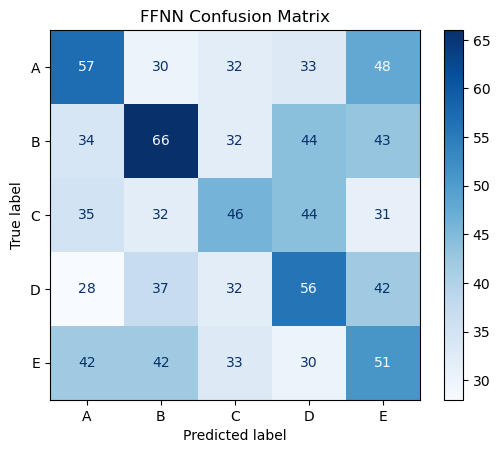


Accuracy per class:
  Class A: 28.50%
  Class B: 30.14%
  Class C: 24.47%
  Class D: 28.72%
  Class E: 25.76%

===== LSTM Model Evaluation =====


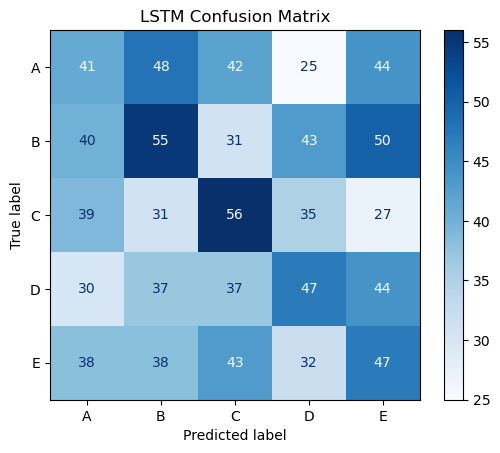


Accuracy per class:
  Class A: 20.50%
  Class B: 25.11%
  Class C: 29.79%
  Class D: 24.10%
  Class E: 23.74%


In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

results = [
    {"Model": "FFNN", "Run": "ffnn_run_lr_1e-3,hid_dim_128", "Val Accuracy": 0.2760, "Params": "hidden=128, lr=1e-3"},
    {"Model": "LSTM", "Run": "lstm_run_lr_1e-4_hid_dim_512", "Val Accuracy": 0.2460, "Params": "hidden=512, lr=1e-4"},
]

df_results = pd.DataFrame(results)
print("Top Models:")
display(df_results)

def plot_confusion_matrix(model, dataloader, device, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3, 4])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C', 'D', 'E'])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(title)
    plt.show()

def accuracy_per_class(model, dataloader, device):
    correct = [0] * 5
    total = [0] * 5

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            logits = model(x_batch)
            preds = torch.argmax(logits, dim=1)

            for i in range(len(y_batch)):
                label = y_batch[i].item()
                pred = preds[i].item()
                total[label] += 1
                if label == pred:
                    correct[label] += 1

    print("\nAccuracy per class:")
    for i in range(5):
        acc = 100 * correct[i] / total[i] if total[i] > 0 else 0
        print(f"  Class {chr(65+i)}: {acc:.2f}%")

print("\n===== FFNN Model Evaluation =====")
ffnn_model = QAClassifierFFNN()
ffnn_model.load_state_dict(torch.load("ffnn_run_lr_1e-3,hid_dim_128_best_model.pt"))
ffnn_model.to(device)

plot_confusion_matrix(ffnn_model, valid_loader, device, title="FFNN Confusion Matrix")
accuracy_per_class(ffnn_model, valid_loader, device)

print("\n===== LSTM Model Evaluation =====")
lstm_model = QAClassifierLSTM(hidden_dim=512)
lstm_model.load_state_dict(torch.load("lstm_run_lr_1e-4_hid_dim_512_best_model.pt"))
lstm_model.to(device)

plot_confusion_matrix(lstm_model, valid_loader_lstm, device_lstm, title="LSTM Confusion Matrix")
accuracy_per_class(lstm_model, valid_loader_lstm, device_lstm,)


## 28. Interpretation & Discussion

**Interpretation:**  
In the final comparison, the Feedforward Neural Network (FFNN) outperformed the LSTM model in terms of validation accuracy, despite being the simpler architecture. The FFNN achieved this result with a large batch size of 4096, while the LSTM used a smaller batch size of 512 due to GPU memory limitations.

This result suggests that for this setup – using static, mean-pooled GloVe embeddings – the FFNN was better suited to the task. The LSTM did not benefit much from sequential modeling, possibly because word order in the input was already lost during mean pooling or because of insufficient training stability.

The confusion matrix for both models showed some imbalance across the answer options (A–E), but the FFNN was more consistent overall. The LSTM seemed to struggle especially with certain classes, possibly due to its higher complexity and limited tuning.

**Limitations & What I would improve next time:**

- **Hyperparameter tuning:**  
  I only tested a small number of settings (e.g., learning rate, hidden dimension). For more robust conclusions, I would invest more time into systematic tuning using wandb sweeps or grid search. Especially test over more epochs - it's not a good sign if the last epoch was the best one. However, due to time and hardware limitations, and the fact that this was not the focus of this project, I decided to stop.

- **Early stopping:**  
  Training was done for a fixed number of epochs. Early stopping based on validation accuracy or loss would help avoid overfitting and save compute time.

- **Evaluation diversity:**  
  I relied mainly on accuracy. Including additional metrics like precision, recall, or F1-score could give a more nuanced view, especially in imbalanced scenarios.

In summary, the FFNN performed better in this setup due to its simplicity, efficient optimization with large batches, and the limited value of sequential modeling in the current embedding strategy. The LSTM model would likely require more tuning and architectural adaptation to show its full potential.


## Tools

- **ChatGPT (Advanced Python GPT)** → Code support, debugging
- **Weights & Biases** → Experiment tracking, logging & model comparison  
  ↳ [docs.wandb.ai](https://docs.wandb.ai/) – Logging & Analysis Documentation  
- **Hugging Face Datasets** → Loading and managing CommonsenseQA  
  ↳ [huggingface.co/datasets](https://huggingface.co/datasets/commonsense_qa)  
- **GloVe (via gensim)** → Pre-trained word embeddings  
  ↳ [nlp.stanford.edu/projects/glove](https://nlp.stanford.edu/projects/glove)  
- **PyTorch Documentation** → Model creation, optimizer setup, loss functions  
  ↳ [pytorch.org/docs](https://pytorch.org/docs/stable/index.html)  
- **Scikit-learn** → Evaluation metrics & confusion matrix  
  ↳ [scikit-learn.org](https://scikit-learn.org/stable/)


**Experiment tracking report:** [View report on WandB](https://wandb.ai/commonsense_qa_jonas_buerge/NLP_Project_1/reports/NLP-Project-1--VmlldzoxMjE3NTU3NA)
